In [ ]:
linear fusion through weights changing

no saved model

In [5]:
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from sensorFusionDataset.creatDataset_2_encoder import CreateDatasets
from sensorFusionDataset.data_split import split_dataset
from sensorFusionNetwork.simpleAutoencoder import SimpleAutoencoder
from testLoop import test_loop
from trainLoop import train_loop
from visualization import plot_losses, plot_metrics,plotTraining
from earlystopping import EarlyStopping

import h5py as h5
from datetime import datetime
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import glob
import time

# local_time =time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())[-8:-1]
now = datetime.now()
dt_string = now.strftime("%Y%m%d_%H%M%S")
# CPU OR GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

damaged_img_path = 'testdataset/damaged_image' 

lidar_mode = 'sparse'

if lidar_mode == 'sparse':
    lidar_path = 'testdataset/lidar_tensor/sparse'
else:
    lidar_path = 'testdataset/lidar_tensor/dense'


label_path = 'testdataset/ori_image'

damaged_img_list = sorted(glob.glob(damaged_img_path + '/*'))
lidar_list = sorted(glob.glob(lidar_path + '/*'))
label_list = sorted(glob.glob(label_path + '/*'))

learning_rate = 1e-4
batch_size = 32

TestDataset = CreateDatasets(label_list, damaged_img_list, lidar_list)
new_testloader = DataLoader(dataset=TestDataset, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

print (f'loading fertig! {device}' )

loading fertig! cuda



KeyboardInterrupt



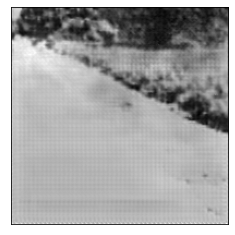

In [2]:
# no retraining
# loading model sparse & FIX
removal_layer = nn.Sequential()

encoder_img = SimpleAutoencoder()
encoder_img.load_state_dict(torch.load('model_save/ori2ori/ori2ori_best_model_600_32_20230518_044338.pth'))
encoder_img.decoder = removal_layer


encoder_lidar = SimpleAutoencoder()
if lidar_mode == 'sparse':
    encoder_lidar.load_state_dict(torch.load('model_save/lidar2img/sparse_FIX_best_model_600_32_20230518_063828.pth'))
else:
    encoder_lidar.load_state_dict(torch.load('model_save/lidar2img/dense_FIX_best_model_600_32_20230518_154020.pth'))
encoder_lidar.decoder = removal_layer


decoder = SimpleAutoencoder()
decoder.load_state_dict(torch.load('model_save/ori2ori/ori2ori_best_model_600_32_20230518_044338.pth'))
decoder.encoder = removal_layer


encoder_img.eval()
encoder_lidar.eval()
decoder.eval()

dataiter = iter(new_testloader)
num_iterations = 10  # Change this to the desired number of iterations

for j in range(num_iterations):
    label, damaged_img, lidar = next(dataiter)

    # fusion and output
    x1 = encoder_img(damaged_img)
    x2 = encoder_lidar(lidar)
    # print(type(x1),type(x2))
    x = 0.5*(x1+x2)
    # x = 0*x1+1*x2
    # x = 0.6*x1+0.4*x2
    # print (x1.shape, x2.shape, x.shape)
    output = decoder(x)
    for i in range(32):
        img4 = output[i].detach().numpy()
        img4 = img4.transpose(1, 2, 0)
        name = '%02d' %i

        plt.xticks([])
        plt.yticks([])
        plt.imshow(img4, cmap='gray')
        # plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
        # plt.margins(0,0)

        plt.savefig('fig_save/Fusion 1/{}_{:02}.png'.format(j,i),bbox_inches = 'tight',transparent = True)

In [2]:
# no retraining
# loading model sparse & FIX
removal_layer = nn.Sequential()

encoder_img = SimpleAutoencoder()
encoder_img.load_state_dict(torch.load('model_save/ori2ori/ori2ori_best_model_600_32_20230518_044338.pth'))
encoder_img.decoder = removal_layer


encoder_lidar = SimpleAutoencoder()
if lidar_mode == 'sparse':
    encoder_lidar.load_state_dict(torch.load('model_save/lidar2img/sparse_FIX_best_model_600_32_20230518_063828.pth'))
else:
    encoder_lidar.load_state_dict(torch.load('model_save/lidar2img/dense_FIX_best_model_600_32_20230518_154020.pth'))
encoder_lidar.decoder = removal_layer


decoder = SimpleAutoencoder()
decoder.load_state_dict(torch.load('model_save/ori2ori/ori2ori_best_model_600_32_20230518_044338.pth'))
decoder.encoder = removal_layer


encoder_img.eval()
encoder_lidar.eval()
decoder.eval()

dataiter = iter(new_testloader)
num_iterations = 10  # Change this to the desired number of iterations

for _ in range(num_iterations):
    label, damaged_img, lidar = next(dataiter)
    # # obtain one batch of test images
    # dataiter = iter(new_testloader)
    # label, damaged_img, lidar = next(dataiter)
    # label, damaged_img, lidar = next(dataiter)
    # label, damaged_img, lidar = next(dataiter)
    # label, damaged_img, lidar = next(dataiter)
    # label, damaged_img, lidar = next(dataiter)
    # label, damaged_img, lidar = next(dataiter)
    # label, damaged_img, lidar = next(dataiter)
    # label, damaged_img, lidar = next(dataiter)

    # fusion and output
    x1 = encoder_img(damaged_img)
    x2 = encoder_lidar(lidar)
    # print(type(x1),type(x2))
    x = 0.5*(x1+x2)
    # x = 0*x1+1*x2
    # x = 1*x1+0*x2
    # print (x1.shape, x2.shape, x.shape)
    output = decoder(x)
    # print(output.shape)

    criterion = nn.MSELoss()
    criterion.to(device)

    batch_size = 32
    count = 0

    for j in range (batch_size):
        img1 = label[j]
        img3 = output[j]
        mse = criterion(img1,img3)
        mse = round(mse.item(),6)
        count = count+mse

    mse_mean = round(count,3)
    print(mse_mean)



1.931
1.301
1.616
2.005
1.432
1.67
1.063
1.286
1.122
1.137


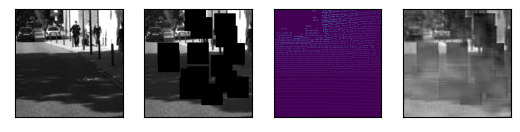

In [3]:
# prep images for display
for i in range(label.shape[0]):
    img1 = label[i].numpy()
    img1 = img1.transpose(1, 2, 0)
    img2 = damaged_img[i].numpy()
    img2 = img2.transpose(1, 2, 0)
    img3 = lidar[i].detach().numpy()
    img3 = img3.transpose(1, 2, 0)
    img4 = output[i].detach().numpy()
    img4 = img4.transpose(1, 2, 0)


    ax = plt.subplot(1, 4, 1)
    plt.xticks([])
    plt.yticks([])
    # ax.set_title('label')
    plt.imshow(img1,cmap='gray')

    ax = plt.subplot(1, 4, 2)
    plt.xticks([])
    plt.yticks([])
    # ax.set_title('damaged image')
    plt.imshow(img2,cmap='gray')

    ax = plt.subplot(1, 4, 3)
    plt.xticks([])
    plt.yticks([])
    # ax.set_title('lidar')
    plt.imshow(img3)

    ax = plt.subplot(1, 4, 4)
    plt.xticks([])
    plt.yticks([])
    #  ax.set_title('reconstructed image')
    plt.imshow(img4,cmap='gray')

    if i == 31:
    # plt.savefig('output_save/5_main_fusion_2/{}.png'.format(i))
plt.show()



In [8]:
from PIL import Image
from torchvision import transforms

toPIL = transforms.ToPILImage()

# print(output.shape)
# prep images for display
for i in range(32):
    img1 = label[i]
    img2 = damaged_img[i]
    img3 = lidar[i]
    img4 = output[i]
    # print(img1.shape, img3.shape)
    # print(type(img1),type(img3))
    # im1 = toPIL(img1)
    im4 = toPIL(img4)
    im3 = toPIL(img3)
    name = '%02d' %i

    # im1.save('RecosntructedImages/ori_img/{}.png'.format(name))
    # im2.save('RecosntructedImages/masked_img/{}.png'.format(name))
    im4.save('fig_save/{}.png'.format(lidar_mode,name))

In [15]:
# MSE for all damages
criterion = nn.MSELoss()
criterion.to(device)


for i, batch in enumerate(new_testloader):# i -->index of batch
    count = 0
    for j in range (batch_size):
        img1 = label[i]
        img3 = output[i]
        mse = criterion(img1,img3)
        mse = round(mse.item(),6)
        count = count+mse

    mse_mean = round(count,3)
    print(mse_mean)

1.871
1.897
1.89
3.475
1.834
1.373
0.72
2.067


IndexError: list index out of range

In [ ]:
--------------------------------

In [6]:
# create testdataset
damage_severity = '3'
damaged_img_path = 'deepEmsemblesDataset/Salt/damaged_image_{}'.format(damage_severity) 


lidar_path = 'deepEmsemblesDataset/lidar_tensor'



label_path = 'deepEmsemblesDataset/ori_image'

damaged_img_list = sorted(glob.glob(damaged_img_path + '/*'))
lidar_list = sorted(glob.glob(lidar_path + '/*'))
label_list = sorted(glob.glob(label_path + '/*'))

learning_rate = 1e-4
batch_size = 32

TestDataset = CreateDatasets(label_list, damaged_img_list, lidar_list)
new_testloader = DataLoader(dataset=TestDataset, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

dataiter = iter(new_testloader)
num_iterations = 1  # Change this to the desired number of iterations

criterion = nn.MSELoss()
criterion.to(device)

# no retraining
# loading model sparse & FIX
removal_layer = nn.Sequential()

encoder_img = SimpleAutoencoder()
encoder_img.load_state_dict(torch.load('model_save/ori2ori/ori2ori_best_model_600_32_20230518_044338.pth'))
encoder_img.decoder = removal_layer


encoder_lidar = SimpleAutoencoder()
if lidar_mode == 'sparse':
    encoder_lidar.load_state_dict(torch.load('model_save/lidar2img/sparse_FIX_best_model_600_32_20230518_063828.pth'))
else:
    encoder_lidar.load_state_dict(torch.load('model_save/lidar2img/dense_FIX_best_model_600_32_20230518_154020.pth'))
encoder_lidar.decoder = removal_layer


decoder = SimpleAutoencoder()
decoder.load_state_dict(torch.load('model_save/ori2ori/ori2ori_best_model_600_32_20230518_044338.pth'))
decoder.encoder = removal_layer


encoder_img.eval()
encoder_lidar.eval()
decoder.eval()



for _ in range(num_iterations):
    label, damaged_img, lidar = next(dataiter)


    batch_size = 32
    count = 0
    x1 = encoder_img(damaged_img)
    x2 = encoder_lidar(lidar)
    # print(type(x1),type(x2))
    x = 0.5*(x1+x2)
    # x = 0*x1+1*x2
    # x = 0.6*x1+0.4*x2
    # print (x1.shape, x2.shape, x.shape)
    output = decoder(x)
    
    for j in range (batch_size):
        img1 = label[j]
        img3 = output[j]
        mse = criterion(img1,img3)
        mse = round(mse.item(),6)
        count = count+mse

    mse_mean = round(count,3)
    print(mse_mean)


 

1.286


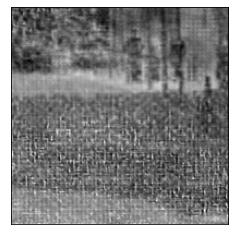

In [7]:
j =31
img4 = output[j].detach().numpy()
img4 = img4.transpose(1, 2, 0)

plt.xticks([])
plt.yticks([])
plt.imshow(img4, cmap='gray')
plt.savefig('fig_save/kk.png',bbox_inches = 'tight',transparent = True)

In [9]:
import cv2
import os
import numpy

masked_region_list = []
original_image_list = []

image_path = 'testdataset/ori_image'
images = sorted(glob.glob(image_path + '/*'))[0:32]
damage_label = 'A'

def create_mask(image_shape, block_size, num_blocks):
    mask = np.ones(image_shape, dtype=np.float32) 
    block_size_px = (int(image_shape[0] * block_size), int(image_shape[1] * block_size))
    np.random.seed(6)
    masked_region = []

    for _ in range(num_blocks):
        top_left = np.random.randint(0, image_shape[0] - block_size_px[0] + 1), np.random.randint(0, image_shape[1] - block_size_px[1] + 1)
        bottom_right = top_left[0] + block_size_px[0], top_left[1] + block_size_px[1]
        mask[top_left[0]:bottom_right[0], top_left[1]:bottom_right[1]] = 0
        masked_region.append((top_left, bottom_right))
        
    return mask, masked_region


for i in range(len(images)):
    image = cv2.imread(images[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ori_img_name = os.path.basename(images[i])

    block_size = 0.2  # 方块大小为原图大小的百分比
    num_blocks = 16  # 方块数量
    mask, masked_region = create_mask(image.shape[:2], block_size, num_blocks)
    masked_region_list.append(masked_region)
    original_image_list.append(image)
    damaged_img1 = image * mask
    # cv2.imwrite(f'testdataset/damaged_image/{damage_label}_{ori_img_name}', damaged_img1)

regional_mse_list = []

for i in range(len(images)):
    original_image = original_image_list[i]
    masked_region = masked_region_list[i]
    original_image = (original_image-np.min(original_image))/(np.max(original_image)-np.min(original_image))
    

    
    # Obtain the output reconstructed image
    output_image = output[i][0].detach().numpy()  # Replace this with the code to get the output image from your image reconstruction network
    # output_image = (output_image-np.min(output_image))/(np.max(output_image)-np.min(output_image))
    
    mse = 0
    num_pixels = 0

    for region in masked_region:
        top_left, bottom_right = region
        original_pixels = original_image[top_left[0]:bottom_right[0], top_left[1]:bottom_right[1]]
        output_pixels = output_image[top_left[0]:bottom_right[0], top_left[1]:bottom_right[1]]
        diff = original_pixels.astype(np.float32) - output_pixels.astype(np.float32)
        mse += np.sum(diff ** 2)
        num_pixels += original_pixels.size

    mse /= num_pixels
    regional_mse_list.append(mse)

print(np.mean(regional_mse_list))

0.09524433820595732


In [10]:
# SSIM

import torch
from skimage.metrics import structural_similarity as ssim
import glob


metric_value_list = []
batch_size = 32


for i, batch in enumerate(new_testloader):
    label, damaged_img, lidar = batch
    count = 0
    for j in range(label.size(0)):
        ori_img_np = label[j][0].detach().cpu().numpy()
        output_np = output[j][0].detach().cpu().numpy()
        ssim_img, diff = ssim(ori_img_np, output_np, full=True, data_range=1.0)
        count = count + ssim_img
    ssim_img = round(count / label.size(0), 3)
    print(ssim_img)
#     metric_value_list.append(ssim_img)

# print(metric_value_list)

0.412
0.28
0.266
0.254
0.234
0.257
0.262
0.253


In [11]:
# LLIPS metrics

import lpips

loss_fn = lpips.LPIPS(net='alex')


for i, batch in enumerate(new_testloader):  # i -->index of batch
    label, damaged_img, lidar = batch
    count = 0
    for j in range(label.size(0)):
        # ori_img_np = ori_img[j][0].detach().numpy()
        # output_np = output[j][0].detach().numpy()
        lpips_img = loss_fn.forward(label, output)
        sum_result = (torch.sum(lpips_img)).item()
        count = count+sum_result
        # count = count.item()
    lpips_img = round(count/label.size(0),3)
    print(lpips_img)
#     metric_value_list.append(lpips_img)

# print(f'scuccess: {metric_value_list}')


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/Anaconda3-2021.11-Linux-x86_64/envs/pytorch/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth
16.545


KeyboardInterrupt: 

In [ ]:
# resnet 50 evaluation
import torch
import torch.nn as nn
import torchvision.models as models

# 加载预训练的ResNet-50模型
resnet = models.resnet50(pretrained=True)

# 替换最后一层全连接层
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, 1)  # 输出为1维

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.001)

# 训练回归模型
def train(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, running_loss))
    print('Training finished.')

# 定义数据集和数据加载器
# 这里假设您已经准备好了您的数据集并将其转换为PyTorch Dataset格式
dataset = MyDataset(...)  # 替换为您的数据集
train_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

# 调用训练函数进行模型训练
train(resnet, train_loader, criterion, optimizer, num_epochs=10)

# 评估模型并输出还原程度的度量值
def evaluate(model, test_loader):
    model.eval()
    metric_values = []
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            metric_values.extend(outputs.flatten().tolist())
    return metric_values

# 定义测试数据集和数据加载器
# 这里假设您已经准备好了测试数据集并将其转换为PyTorch Dataset格式
test_dataset = MyDataset(...)  # 替换为您的测试数据集
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# 调用评估函数获取还原程度的度量值
metric_values = evaluate(resnet, test_loader)

# metric_values包含了输入经过reconstruction的受损图的还原程度度量值
print(metric_values)
